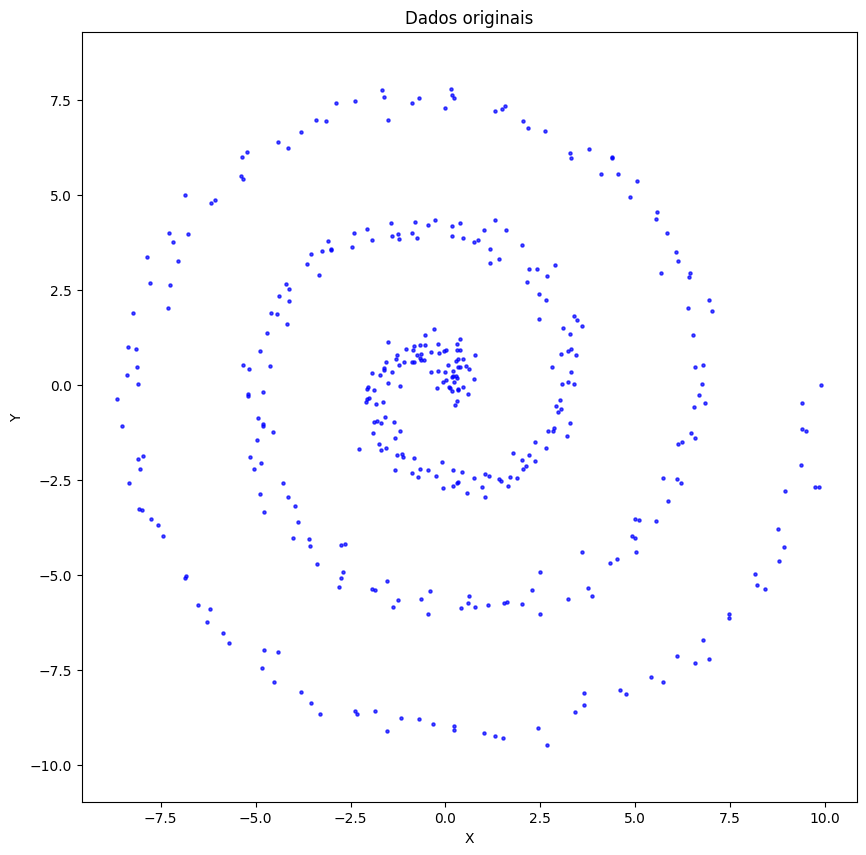

In [8]:
# Import Dataset
import pandas as pd
import matplotlib.pyplot as plt

# Load the spiral data from the CSV file
file_path = '../data/spiral_data.csv'  # Update the path if necessary
spiral_data = pd.read_csv(file_path)

# Extract x and y coordinates
x = spiral_data['x']
y = spiral_data['y']

# Plot the spiral
plt.figure(figsize=(10, 10))
plt.scatter(x, y, color='blue', alpha=0.7, s=5)
plt.axis('equal')
plt.title("Dados originais")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

Número de Clusters: 31


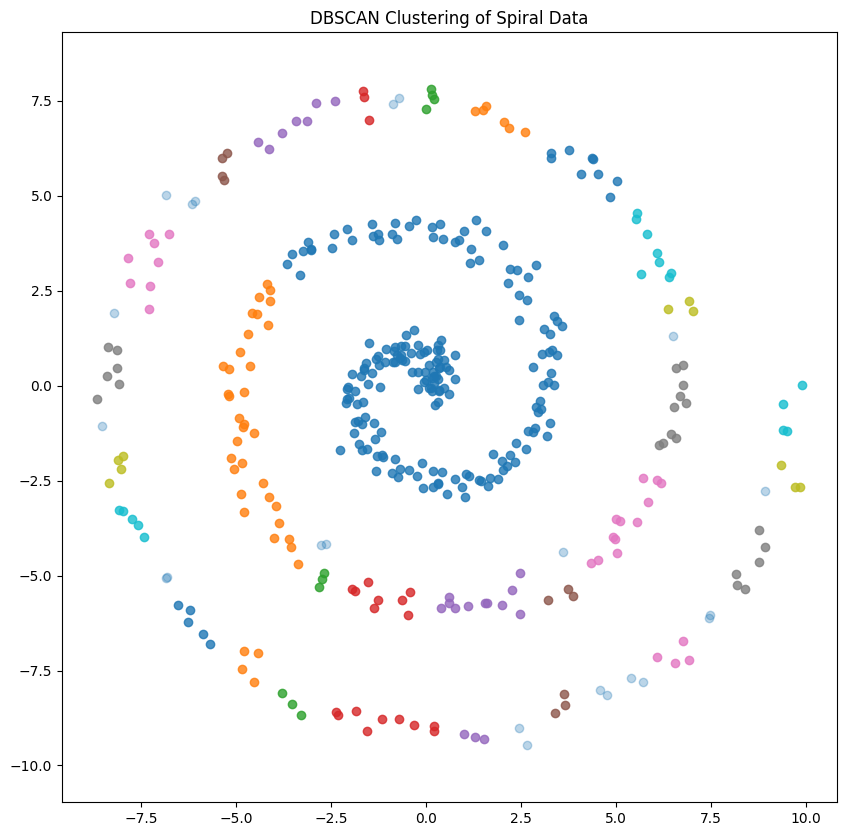

In [9]:
# DBSCAN
from sklearn.cluster import DBSCAN
import numpy as np

# Parameters for DBSCAN
eps = 0.7  # Maximum distance between two samples to be considered neighbors
min_samples = 3  # Minimum number of points in a neighborhood to form a cluster

# Stack x and y into a single array for clustering
coordinates = np.column_stack((x, y))

# Apply DBSCAN
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
labels = dbscan.fit_predict(coordinates)

# Plot the clusters
plt.figure(figsize=(10, 10))
unique_labels = set(labels)
for label in unique_labels:
    if label == -1:  # Noise points
        color = 'gray'
        alpha = 0.3
    else:
        color = None  # Let matplotlib auto-assign colors to clusters
        alpha = 0.8
    cluster_points = coordinates[labels == label]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {label}", alpha=alpha)
print('Número de Clusters:', len(unique_labels))
plt.axis('equal')
plt.title("DBSCAN Clustering of Spiral Data")
plt.show()


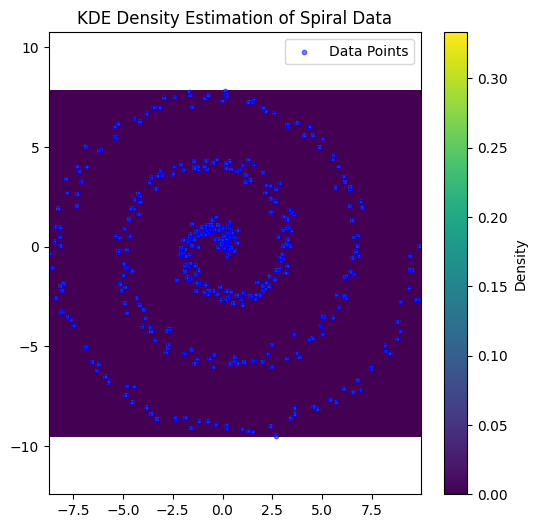

In [10]:
# Kernel Density
from sklearn.neighbors import KernelDensity
from matplotlib.colors import Normalize

# Fit KDE
kde = KernelDensity(kernel='gaussian', bandwidth=0.05).fit(coordinates)

# Evaluate KDE on a grid
x_grid = np.linspace(x.min(), x.max(), 200)
y_grid = np.linspace(y.min(), y.max(), 200)
X_grid, Y_grid = np.meshgrid(x_grid, y_grid)
grid_points = np.column_stack([X_grid.ravel(), Y_grid.ravel()])

# Calculate density values
log_density = kde.score_samples(grid_points)
density = np.exp(log_density).reshape(X_grid.shape)

# Plot KDE density
plt.figure(figsize=(6, 6))
plt.pcolormesh(X_grid, Y_grid, density, shading='auto', cmap='viridis', norm=Normalize(vmin=0, vmax=density.max()))
plt.colorbar(label="Density")
plt.scatter(x, y, color='blue', alpha=0.5, s=10, label="Data Points")
plt.title("KDE Density Estimation of Spiral Data")
plt.legend()
plt.axis('equal')
plt.show()

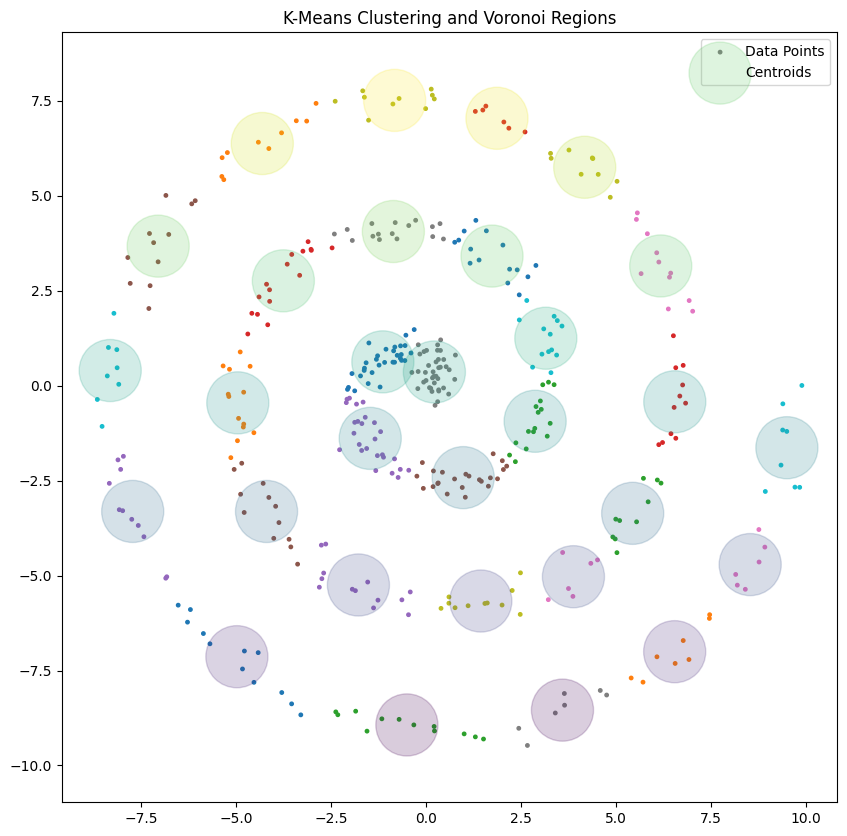

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.spatial import Voronoi, voronoi_plot_2d

# Generate synthetic data
np.random.seed(42)
coordinates = np.column_stack((x, y))

# Apply K-Means Clustering
n_clusters = 30  # Number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(coordinates)
centroids = kmeans.cluster_centers_

# Plotting K-Means Clusters
plt.figure(figsize=(10, 10))
plt.scatter(coordinates[:, 0], coordinates[:, 1], c=labels, cmap='tab10', s=6, label='Data Points')
plt.scatter(centroids[:, 0], centroids[:, 1], c=centroids[:, 1], marker='o', s=2000, label='Centroids', alpha=0.2)
plt.xlim(-12, 12)
plt.ylim(-12, 12)

# Customize plot
plt.title("K-Means Clustering and Voronoi Regions")
plt.legend()
plt.axis('equal')
plt.show()

In [1]:

import numpy as np

def create_line_segment(center, direction, length):
    """
    Create a line segment with mean in point A, direction D, and length L.

    Parameters:
        A (array-like): The mean of the line segment (e.g., [x, y]).
        D (array-like): The direction of the line segment (e.g., [dx, dy]).
        L (float): The length of the line segment.

    Returns:
        tuple: Two points representing the endpoints of the line segment.
    """
    # Convert inputs to NumPy arrays
    center = np.array(center)
    direction = np.array(direction)

    # Normalize the direction vector
    D_normalized = direction / np.linalg.norm(direction)


    # Calculate the endpoint
    startpoint = center - length / 2 * D_normalized    
    endpoint = center + length / 2 * D_normalized

    # Return the two endpoints of the line segment
    return np.array([startpoint, endpoint])

def distance_point_to_segment(point, segment):
    # Descompactar coordenadas
    px, py = point
    segment_start, segment_end = segment
    x1, y1 = segment_start
    x2, y2 = segment_end

    # Vetores
    AP = np.array([px - x1, py - y1])
    AB = np.array([x2 - x1, y2 - y1])
    
    # Comprimento ao quadrado do segmento
    AB_length_squared = AB.dot(AB)
    
    if AB_length_squared == 0:
        # A e B são o mesmo ponto
        return np.linalg.norm(AP)
    
    # Projeção escalar
    t = AP.dot(AB) / AB_length_squared

    # Restringir t ao intervalo [0, 1] (será que se colocarmos uma margem ou um ruído para permitir que as linhas crescam e diminuam, dá bom?)
    if (t < 0): t = 0
    if (t > 1): t = 1
    
    # Ponto projetado no segmento
    projection = np.array([x1, y1]) + t * AB
    
    # Distância euclidiana entre P e a projeção
    distance = np.linalg.norm(np.array([px, py]) - projection)
    
    return distance


In [26]:
import numpy as np
from sklearn.decomposition import PCA
import time
import matplotlib.pyplot as plt 

def get_new_segment(data, segments):
    if (len(segments) == 0):
        return update_single_segment(data)
    
    min_total_distance = float('inf')
    best_point = None
    min_distances = []
    start_time = time.time()
    for point in data:
        segments_distances = [distance_point_to_segment(point, segment) for segment in segments]
        min_distances.append([point, min(segments_distances)])
    print(f"Time to calc segments distances: {time.time() - start_time:.4f} seconds")
    
    start_time = time.time()
    for candidate_point in data:        
        total_distance = 0
        
        for point_dist in min_distances:            
            point, dist = point_dist
            point_to_candidate_dist = np.linalg.norm(point - candidate_point) 
            total_distance += min(dist, point_to_candidate_dist)
        if total_distance < min_total_distance:
            min_total_distance = total_distance
            best_point = candidate_point
    print(f"Time to calc best point: {time.time() - start_time:.4f} seconds")
    
    # Return the best point as the new segment
    return np.array([best_point, best_point])
    
    
def update_single_segment(cluster_points):        
    pca = PCA(n_components=1)
    pca.fit(cluster_points)
    direction = pca.components_[0]
    std_dev = np.sqrt(pca.explained_variance_[0])           
    length = 3 / 2 * std_dev 
    mean = cluster_points.mean(axis=0)
    return create_line_segment(mean, direction, length)              
    
def assign_points_to_segments(data, segments):
    assignments = []
    for point in data:
        distances = [distance_point_to_segment(point, segment) for segment in segments]
        assignments.append(np.argmin(distances))
    return assignments


def update_segments(data, assignments, k):
    segments = []
    for i in range(k):
        cluster_points = data[np.array(assignments) == i]
        if len(cluster_points) > 0:
            segment = update_single_segment(cluster_points)
            segments.append(segment)  
                  
    return segments

from scipy.spatial.distance import cdist
def order_segments(segments):
    '''
    Ordena Segmentos e também a componente principal ortogonal  
    '''
    # Lista para armazenar a ordem dos segmentos
    ordered_segments = []

    # Usar o primeiro segmento como ponto inicial
    current_segment = segments[0]
    ordered_segments.append(current_segment)
    # ordered_pcs = [ortogonal_components[0]]
    current_start, current_end = current_segment

    # Criar uma lista dos segmentos restantes
    remaining_segments = list(segments[1:])
    # remaining_pcs = list(ortogonal_components[1:])


    while remaining_segments:
        # Criar uma lista com todos os extremos dos segmentos restantes
        candidates = []
        for seg in remaining_segments:
            candidates.extend(seg)
        candidates = np.array(candidates)
        
        # Calcular a menor distância entre o ponto final do segmento atual e os candidatos
        distances_end = cdist([current_end], candidates)
        distances_start = cdist([current_start], candidates)
        min_idx_end = np.argmin(distances_end)
        min_dist_end = np.min(distances_end)
        min_idx_start = np.argmin(distances_start)
        min_dist_start = np.min(distances_start)
        
        if min_dist_start > min_dist_end:  
            next_segment_idx = min_idx_end // 2
            next_segment = remaining_segments[next_segment_idx]
            # ordered_pcs.append(remaining_pcs[next_segment_idx])
            if min_idx_end % 2 == 0:
                current_end = next_segment[1] 
                ordered_segments.append(next_segment)
            else:
                current_end = next_segment[0] 
                ordered_segments.append([next_segment[1], next_segment[0]])
                
        else:
            next_segment_idx = min_idx_start // 2
            next_segment = remaining_segments[next_segment_idx]
            # ordered_pcs.insert(0, remaining_pcs[next_segment_idx])
            if min_idx_start % 2 == 0:
                current_start = next_segment[1] 
                ordered_segments.insert(0, [next_segment[1], next_segment[0]])
            else:
                current_start = next_segment[0] 
                ordered_segments.insert(0, next_segment)
            
        # Remover o segmento já utilizado
        del remaining_segments[next_segment_idx]
        # del remaining_pcs[next_segment_idx]

    return np.array(ordered_segments)

def calc_connection_seg(seg_prev, pc_prev, seg_current, pc_current):
    pc_norm = (np.linalg.norm(pc_current) + np.linalg.norm(pc_prev)) / 2
    return {
        'max_dist': pc_norm,
        'seg_points': np.array([seg_prev[1], seg_current[0]]),
        'is_conn': True
    }   
      
def extract_final_curve(ordered_segments, ordered_pcs):
    final_curve = []
    for i, segment in enumerate(ordered_segments):                
        final_curve.append({
            # 'ortogonal_pc': ordered_pcs[i],
            'seg_points': segment,
            'is_conn': False
        }) 
        if (i>=1 and i < len(ordered_segments)):
            conn_seg = calc_connection_seg(ordered_segments[i-1], ordered_pcs[i-1], segment, ordered_pcs[i])        
            final_curve.append(conn_seg)
    return final_curve

def k_segments_algorithm(data, k_max=5):    
    segments = [get_new_segment(data, [])]
    history = [[segments, [], "k = 1"]]
    ordered_segments, connection_segments = [[],[]]
    for k in range(1, k_max + 1):
        new_seg = get_new_segment(data, segments)
        segments.append(new_seg)
        
        voronoi_regions = assign_points_to_segments(data, segments)
                
        segments = update_segments(data, voronoi_regions, k)
        
        ordered_segments, connection_segments = connect_segments_to_line(segments.copy())
        history.append([ordered_segments, connection_segments, "k = " + str(k)])
    return segments, connection_segments, history
        
def load_data(file_path): 
    print("loading data")
    all_data = pd.read_csv(file_path)
    train_data = all_data.to_numpy()[:, 1:]
    labels = all_data.to_numpy()[:, 0]
    print(f"train shape: {train_data.shape}")
    print(f"labels shape: {labels.shape}")
    
    return train_data, labels

import pandas as pd
train_data_file_path = 'C:/src/data_analysis/data/digit-recognizer/train.csv'
X_train, y_train = load_data(train_data_file_path)
sample_image = X_train[3].reshape(28,28) # Escolher a primeira imagem (28x28)
rows, cols = np.nonzero(sample_image)  # Obtemos as coordenadas (x, y) dos pixels não nulos
coordinates = np.column_stack((rows, cols))
ordered_segments, connection_segments, segments_history = k_segments_algorithm(coordinates, 8)
plt.scatter(rows, cols)

def plot_segments(segments, plt, isConnection):
    """
    Plots a line between each consecutive pair of points in a NumPy array.

    Parameters:
        points (numpy.ndarray): A 2D array of shape (n, 2),
         where each row is a point [x, y].
    """
    color='b'
    width=5
    if (isConnection):
        color='r'
        width=1
        
    for i in range(len(segments)):
        # Extract consecutive pairs of points
        start, end = segments[i]

        # Plot the line between the points
        plt.plot([start[0], end[0]], [start[1], end[1]], color, linewidth=width)
        
plot_segments(ordered_segments, plt, False)
plot_segments(connection_segments, plt, True)

ModuleNotFoundError: No module named 'cdist'

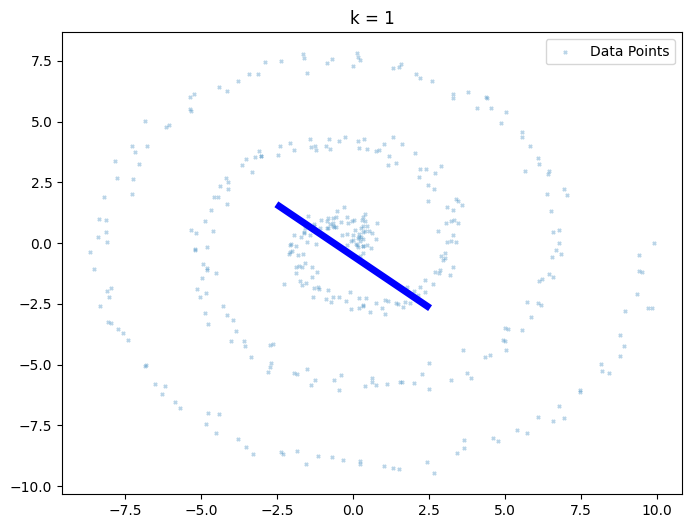

In [172]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from IPython.display import HTML


# Animation
fig, ax = plt.subplots(figsize=(8, 6))

def update(frame):
    ax.clear()
    ordered_segments, connection_segments, title = segments_history[frame]
    ax.scatter(coordinates[:, 0], coordinates[:, 1], alpha=0.3, s=5, label='Data Points', marker='x')
    plot_segments(ordered_segments, ax, isConnection=False)
    plot_segments(connection_segments, ax, isConnection=True)
    ax.legend()
    ax.set_title(title)

ani = FuncAnimation(fig, update, frames=len(segments_history), repeat=False)
HTML(ani.to_jshtml())


In [173]:
ani.save("k_segments_animation.gif", writer=PillowWriter(fps=2))

Dúvidas/ideias:
1. A parte de suavização entra na conta do algoritmo a cada iteração ou só é calculada no final, depois de todos os segmentos terem sido determinados? Como é calculada a suavização?
3. Olhando para os datasets dos artigos de 2019 me veio uma ideia que pode auxiliar na classficação:
    E se ao invés de serem linhas unidimensionais, criarmos linhas com uma "grossura"? 
    Para fazer isso, uma boa heurística seria utilizar a segunda componente principal. 
    Isso aumentaria a dimensão resultante e a complexidade, mas talvez, para datasets com muitas variáveis e não muitos dados, seja interessante.
    3.1 no artigo de 2023 o valor utilizado para calcular a dimensão ortogonal do "k_cilinders" é constante, mas e se utilizarmos o valor da da segunda componente principal como direção e o valor de 2/3 do desvio padrão dessa segunda componente como magnitude da distância que cada segmento considerará pertencente à classe? Assim, no cálculo em fase de operação, basta:
        1. Determinar o segmento mais próximo (i) do ponto a ser classificado
        2. Verificar se a projeção ortogonal do ponto sobre o vetor da segunda componente principal do segmento i está entre 0 e 1 (extremidades inclusas). Se estiver, significa que o ponto está dentro da região
    Obs: Se usarmos PCs de ordem maior, podemos verificar mais projeções ortogonais por ponto. Para cada PC adicional, minha intuição é que ganharíamos uma precisão maior, no entanto, a curva pricipal resultante teria uma dimensão a mais para cada PC adicionada, aumentando a complexidade de treino e validação. Vale o teste para confirmar. Me parece que esse procedimento seria 100% determinístico e teria o potencial de aproximar qualquer conjunto de dados de N dimensões com distribuições variadas para uma série de gaussianas "distorcidas" de M dimensões para cada segmento do k_seg. Dessa maneira, poderíamos aproximar qualquer conjunto de dados, focando apenas no número de dimensões, na convergência e tempo de iterações 


4. Me parece que na função para encontrar os índices foi feita uma seleção dos dados com base no buffer, para poupar memória.
No entanto, me parece que isso não foi levado em consideração no calculo da PCA. 
Lendo a documentação da (scikit learn)[https://scikit-learn.org/dev/modules/generated/sklearn.decomposition.PCA.html], isso é equivalente a se utilizar "dados esparsos". Ou seja, o calculo das componentes principais é realizado de forma aleatória. Isso faz o algoritmo deixar de ser determinístico. 

5. Acredito que se isso foi levado em conta desde o começo, o parâmetro log likelyhood do Verbeek, que não apresentou melhorias neste caso, poderia auxiliar no cálculo caso todos os pontos sejam levados em conta

6. Acho que se utilizarmos a função da sci kit learn da classe PCA para calcular as componentes principais, pois eles provavelmente fazem uma otimização. Além disso, eles já implementaram a parte aleatória cm dados esparsos, e talvez seja útil caso precisemos de performance  

7. O que acha de usar Bayesian LSTM com previsão de dados futuros? https://arxiv.org/abs/1709.01907
Pensei que poderíamos usar cada casa como uma time series diferente para prever a demanda indivdual. E depois, usamos as timeseries em conjunto para prever a demanda geral com um certo grau de incerteza. Assim, seria possível prever falhas de forma mais eficiente. Isso é útil principalmente para prever como as microgrids irão se comportar em D+1 e determinar as medidas para evitar sobrecargas (estava falando com um aluno da disciplina que trabalha com isso).